In [135]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import sys
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert, classes
import numpy as np
import imp
import pandas as pd
import seaborn as sns
from sklearn_crfsuite import CRF
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from operator import itemgetter
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# import sklearn.grid_search

In [136]:
dir_name='duplicate'
final_pred_name='merged.crf.bert.ens.c.w.l'
final_feature_name='local.plot.tfidf.30'
dataset_name='dataset_tf.word.char.lemma.full_splits'
cv_split_name='cv_splits_per_client'
seq_len=15
step=15
file_prefix='threshold'

In [137]:
all_pred_crf01=common_utils.load_db(dir_name,final_pred_name)

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/merged.crf.bert.ens.c.w.l.csv,  index False


In [152]:
all_pred_crf01

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,sent_idx,crf_group,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true,ens_par
0,1,0,1,0,0.45525,0.54475,0,0,0,1,...,0.930,0.070,0,0,0.84699,0.15301,1,0,0,0
1,1,0,0,0,0.76593,0.23407,1,1,1,1,...,0.943,0.057,1,0,0.84595,0.15405,1,0,0,1
2,1,0,0,0,0.79398,0.20602,2,2,2,1,...,0.972,0.028,2,0,0.84583,0.15417,1,0,0,2
3,1,0,0,0,0.59757,0.40243,3,3,3,1,...,0.957,0.043,3,0,0.84611,0.15389,1,0,0,3
4,1,0,1,0,0.40709,0.59291,4,4,4,1,...,0.968,0.032,4,0,0.84717,0.15283,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,7,0,0,0.70014,0.29986,2983,171,254,79,...,0.872,0.128,2983,0,0.84198,0.15802,79,7,0,171
38430,79,7,0,0,0.84534,0.15466,2984,172,255,79,...,0.994,0.006,2984,0,0.84326,0.15674,79,7,0,172
38431,79,7,0,0,0.85442,0.14558,2985,172,256,79,...,0.999,0.001,2985,0,0.84387,0.15613,79,7,0,172
38432,79,7,0,0,0.84201,0.15799,2986,172,257,79,...,1.000,0.000,2986,0,0.84348,0.15652,79,7,0,172


In [138]:
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/cv_splits_per_client.json


In [139]:
splits_hold_one=common_utils.load_json(dir_name,'splits_hold_one')

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/splits_hold_one.json


In [140]:
splits_train={}
splits_test={}

for k,v in splits_hold_one.items():
    if k=='0':
        splits_test[k]=v
    else:
        splits_train[k]=v

In [141]:
imp.reload(classes)


<module 'classes' from './src/classes.py'>

In [142]:
imp.reload(classes)
prob_wrapper=classes.MyProbWrapper(data=all_pred_crf01,splits_train=splits_train,splits_test=splits_test)


init >> MyProbWrapper, model prefix bert, total train splits 7
group: (38434,) y (38434,) X (38434, 4)


# Check only SGD params

In [143]:
imp.reload(classes)
param_grid = {
    "loss" : ["log", "modified_huber"],
    "alpha" : np.linspace(0.00001,0.0001,num=20),
    "penalty" : ["l2", "l1", "none"],
}
clf=SGDClassifier()
my_grid=classes.MyGrid(refit_score='nar_recall_score')
my_grid.search_and_shows(
prob_wrapper=prob_wrapper,
clf=clf,
param_grid=param_grid)

init >> MyGrid
Fitting 7 folds for each of 120 candidates, totalling 840 fits
Best params for nar_recall_score
{'alpha': 3.842105263157895e-05, 'loss': 'modified_huber', 'penalty': 'none'}

Confusion matrix of SGDClassifier optimized for nar_recall_score on the 6365 test data:
     pred_neg  pred_pos
neg      4299       456
pos       806       804


,mean_test_nar_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score
41,0.639987,0.502015,0.797968,0.712268
16,0.656178,0.488004,0.798336,0.711153
35,0.661330,0.462049,0.798744,0.708926
32,0.662348,0.465513,0.797893,0.707607
29,0.651017,0.480584,0.794905,0.707202


In [148]:
my_grid.grid_search.best_params_

{'alpha': 3.842105263157895e-05, 'loss': 'modified_huber', 'penalty': 'none'}

# Find best regressor

In [65]:
param_grid = [
{'regressor': [SGDClassifier()],
#                "regressor__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
                "regressor__alpha" : np.linspace(0.00001, 0.0002, num=20),
                "regressor__loss" : ["log", "modified_huber"],
                "regressor__penalty" : ["l2", "l1", "none"]} ,
#               {'regressor': [RidgeClassifier()],
#                'regressor__alpha': [1,0.1,0.01,0.001,0.0001,0], 
#                "regressor__fit_intercept": [True, False]},
#               {'regressor': [LogisticRegression(n_jobs=-1)],
#               'regressor__C' :np.logspace(-3,3,7), 
#                "regressor__penalty":["l1","l2"]},
#               {'regressor': [DecisionTreeClassifier()],
#               'regressor__max_depth': np.arange(3,10,1),
#                'regressor__min_samples_leaf': np.arange(3,10,1)},
#               {'regressor': [SVC(probability=True)],
#                 'regressor__C': [0.1,1, 10, 100],
#                 'regressor__gamma': [1,0.1,0.01,0.001],
#                'regressor__kernel': ['rbf', 'poly', 'sigmoid']}
             ]

In [53]:
param_grid[0]['regressor'][0]

SGDClassifier()

In [66]:
pipe = Pipeline([('regressor', RidgeClassifier())])
my_grid=classes.MyGrid(refit_score='nar_recall_score')
my_grid.search_and_shows(
prob_wrapper=prob_wrapper,
clf=pipe,
param_grid=param_grid)


init >> MyGrid
Fitting 7 folds for each of 120 candidates, totalling 840 fits
Best params for nar_recall_score
{'regressor': SGDClassifier(alpha=2e-05, loss='modified_huber', penalty='l1'), 'regressor__alpha': 2e-05, 'regressor__loss': 'modified_huber', 'regressor__penalty': 'l1'}

Confusion matrix of Pipeline optimized for nar_recall_score on the 6365 test data:
     pred_neg  pred_pos
neg      3816       939
pos       530      1080


,mean_test_nar_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
21,0.650582,0.504200,0.802694,0.716193,0.810786
10,0.639532,0.516867,0.796540,0.711250,0.803633
3,0.646477,0.510530,0.794870,0.707552,0.804176
35,0.659250,0.468073,0.798531,0.706548,0.810084
108,0.676721,0.447954,0.797320,0.704436,0.810504


In [67]:
my_grid.results.sort_values(by=['mean_test_nar_recall_score','mean_test_f1_micro_score'],ascending=False)[my_grid.columns].head()

,mean_test_nar_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
10,0.639532,0.516867,0.796540,0.711250,0.803633
3,0.646477,0.510530,0.794870,0.707552,0.804176
21,0.650582,0.504200,0.802694,0.716193,0.810786
5,0.659703,0.473156,0.794051,0.699596,0.806225
58,0.647825,0.471906,0.794030,0.704181,0.804825


In [68]:
my_grid.grid_search.best_estimator_

Pipeline(steps=[('regressor',
                 SGDClassifier(alpha=2e-05, loss='modified_huber',
                               penalty='l1'))])

In [69]:
my_grid.grid_search.best_params_

{'regressor': SGDClassifier(alpha=2e-05, loss='modified_huber', penalty='l1'),
 'regressor__alpha': 2e-05,
 'regressor__loss': 'modified_huber',
 'regressor__penalty': 'l1'}

In [70]:
best_classifier=SGDClassifier(
penalty='l1',
alpha=2e-05,
loss='modified_huber')

In [71]:
common_utils.save_db(my_grid.results,dir_name,'grid.sgc.ens.params')

Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/grid.sgc.ens.params.csv, 
index False
float_format %.5f


# Find threshold for the best classifier

In [161]:
imp.reload(classes)


<module 'classes' from './src/classes.py'>

init >> MyGrid
Fitting 7 folds for each of 70 candidates, totalling 490 fits
[0 1]
X shape (6365, 2)
Best params for f1_weighted_score
{'thresholdclassifier__threshold': 0.976231884057971}

Confusion matrix of Pipeline optimized for f1_weighted_score on the 6365 test data:
     pred_neg  pred_pos
neg      1113      3642
pos        57      1553


,mean_test_nar_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_custom_score
64,0.014075,0.002781,0.637985,0.424979,0.382759
60,0.009078,0.003446,0.634925,0.423156,0.381185
62,0.008818,0.008532,0.632104,0.423119,0.381660
66,0.017703,0.014737,0.614261,0.410535,0.370955
65,0.013230,0.015294,0.605655,0.406460,0.367343


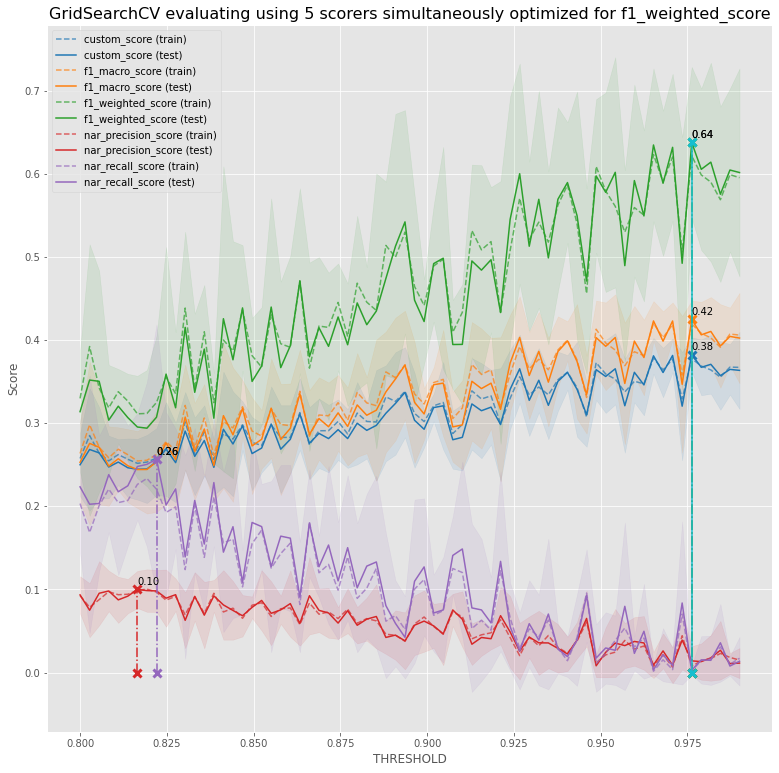

In [162]:
imp.reload(classes)

th_pipe=make_pipeline(classes.PredictionTransformer(
                        SGDClassifier(
                            alpha=3.842105263157895e-05,
                            loss='modified_huber', 
                            penalty='none'
                        )
                     ),
                     classes.ThresholdClassifier())
threshold_params = {
    'thresholdclassifier__threshold': np.linspace(0.80, 0.99, num=70)
    }

th_grid=classes.MyGrid(refit_score='f1_weighted_score',recall_weight=0.1)
th_grid.search_and_shows(
prob_wrapper=prob_wrapper,
clf=th_pipe,
param_grid=threshold_params)
th_grid.plot(param='thresholdclassifier__threshold')

In [131]:
my_grid_map['f1_macro_score'].results.sort_values(by=['mean_test_f1_macro_score','mean_test_nar_recall_score'],ascending=False)[my_grid_map['f1_macro_score'].columns].head()

KeyError: 'f1_macro_score'

In [132]:
# grid_search_clf = grid_search_wrapper(pipe,param_grid,refit_score='nar_recall_score')
# results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_nar_recall_score', ascending=False)
results_recall[columns].head()

NameError: name 'results_recall' is not defined

In [133]:
grid_search_clf = grid_search_wrapper(pipe,param_grid,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

NameError: name 'grid_search_wrapper' is not defined

In [134]:
grid_search_clf = grid_search_wrapper(pipe,param_grid,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

NameError: name 'grid_search_wrapper' is not defined